# <font color="blue">Imports</font>

In [2]:
# Import des libraires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import t, shapiro, pearsonr, kstest
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import preprocessing
from sklearn.cluster import KMeans

In [3]:
# Import Data
billets = pd.read_csv("Data/billets.csv",sep = ";") 

# <font color="blue"> Analyse exploratoire </font>

In [4]:
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [5]:
billets.describe(include="all")

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN
top,True,NaN,NaN,NaN,NaN,NaN,NaN
freq,1000,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,NaN,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,NaN,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,NaN,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,NaN,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,NaN,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000


##### <font color="green"> Des valeurs manquantes sur la variable "margin_low", on va d'abord explorer les données en les omettant puis choisir la meilleure manière de les imputer  </font>

In [6]:
df = billets[~pd.isna(billets.margin_low)]

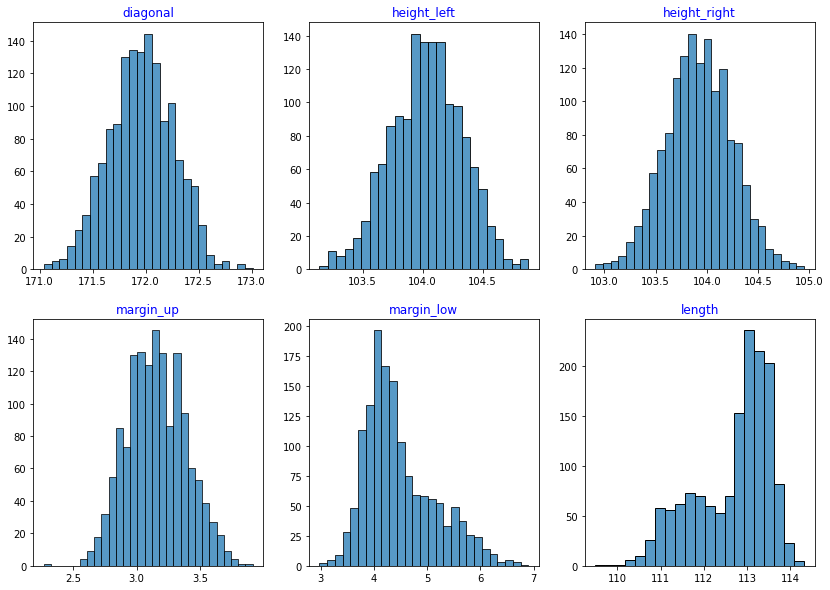

In [7]:
# Analyse des distributions
df_num = df[["diagonal", "height_left", "height_right", "margin_up", "margin_low", "length"]]
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14,10))
for col, i, j in zip(df_num.columns, [0,0,0,1,1,1], [0,1,2,0,1,2]):
    g = sns.histplot(ax=ax[i,j], data=df_num, x=col) 
    g.set(xlabel='', ylabel='')
    g.set_title(col, c="blue")

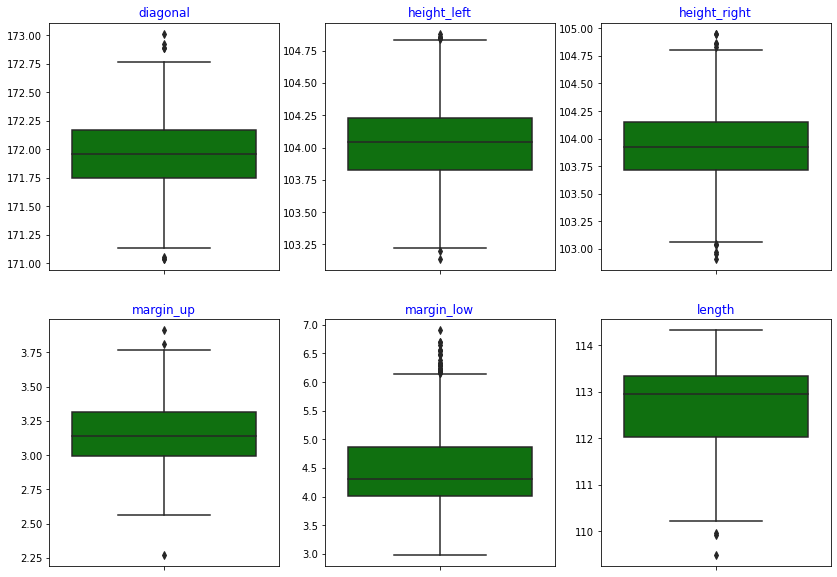

In [8]:
# Boxplot
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14,10))
for col, i, j in zip(df_num.columns, [0,0,0,1,1,1], [0,1,2,0,1,2]):
    g = sns.boxplot(ax=ax[i,j], data=df_num, y=col, color="green") 
    g.set(xlabel='', ylabel='')
    g.set_title(col, c="blue")

<AxesSubplot:>

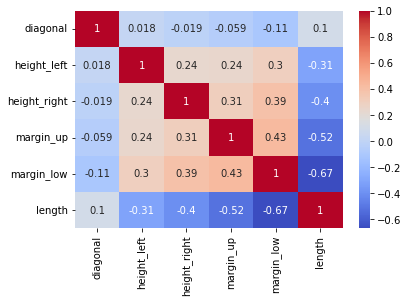

In [9]:
# Analyse des corrélations
tc=df_num.corr()
sns.heatmap(tc,annot=True,cmap="coolwarm")

In [10]:
# Test des corrélations
for col1 in df_num.columns:
    for col2 in df_num.columns:
        if col1 != col2 :
            coef, p_value = pearsonr(df_num[col1], df_num[col2])
            if p_value <= 0.01 :
                print("Corrélation entre ",col1," et ",col2, " (p_value : ", round(p_value,2),")")

Corrélation entre  diagonal  et  margin_low  (p_value :  0.0 )
Corrélation entre  diagonal  et  length  (p_value :  0.0 )
Corrélation entre  height_left  et  height_right  (p_value :  0.0 )
Corrélation entre  height_left  et  margin_up  (p_value :  0.0 )
Corrélation entre  height_left  et  margin_low  (p_value :  0.0 )
Corrélation entre  height_left  et  length  (p_value :  0.0 )
Corrélation entre  height_right  et  height_left  (p_value :  0.0 )
Corrélation entre  height_right  et  margin_up  (p_value :  0.0 )
Corrélation entre  height_right  et  margin_low  (p_value :  0.0 )
Corrélation entre  height_right  et  length  (p_value :  0.0 )
Corrélation entre  margin_up  et  height_left  (p_value :  0.0 )
Corrélation entre  margin_up  et  height_right  (p_value :  0.0 )
Corrélation entre  margin_up  et  margin_low  (p_value :  0.0 )
Corrélation entre  margin_up  et  length  (p_value :  0.0 )
Corrélation entre  margin_low  et  diagonal  (p_value :  0.0 )
Corrélation entre  margin_low  et  

##### <font color="green"> La variable "margin_low" est corrélée aux autres variables, on va imputer les valeurs manquantes par régression linéaire  </font>

# <font color="blue"> Régression linéaire </font>

In [11]:
# Mise en place de la regression linéaire multiple
x = df[["diagonal", "height_left", "height_right", "margin_up", "length"]]
x = sm.add_constant(x)
y = df[["margin_low"]]
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=2)
reg = sm.OLS(ytrain, xtrain).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             margin_low   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     187.9
Date:                Fri, 19 Aug 2022   Prob (F-statistic):          8.84e-142
Time:                        18:02:05   Log-Likelihood:                -696.35
No. Observations:                1024   AIC:                             1405.
Df Residuals:                    1018   BIC:                             1434.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           21.8672     11.427      1.914      0.056      -0.556      44.290
diagonal        -0.1120      0.050     -2.248      0.025      -0.210      -0.014
height_left      0.1915      0.055      3.512      0.000       0.085       0.299
height_right     0.2605      0.051      5.069      0.000       0.160       0.361
margin_up        0.2661      0.076      3.487      0.001       0.116       0.416
length          -0.4079      0.022    -18.783      0.000      -0.451      -0.365
==============================================================================
Omnibus:                       43.514   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.022
Skew:                           0.437   Prob(JB):                     1.86e-12
Kurtosis:                       3.709   Cond. No.                     1.93e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.93e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
def score(x,y,reg):
    n = len(y)
    p = x.shape[1]-1
    y_moy = y.mean()
    y_pred = reg.predict(x)
    SCT = sum([(y.iloc[i]-y_moy)**2 for i in range(len(y))])
    SCE = sum([(y_pred.iloc[i]-y_moy)**2 for i in range(len(y))])
    R = SCE/SCT
    R_adj = 1 - (n/(n-p))*(1-R)
    return round(R_adj,3)
score(xtest,ytest,reg)

margin_low    0.479
dtype: float64

##### <font color="green"> le R adjusted est proche entre le training model et le testing model </font>

##### <font color="black"> Analyse des observations influentes </font>

In [12]:
alpha = 0.05
n = xtrain.shape[0]
p = 6

In [13]:
analyses = pd.DataFrame({'obs':np.arange(1, n+1)})
analyses['levier'] = reg.get_influence().hat_matrix_diag
seuil_levier = 2*p/n

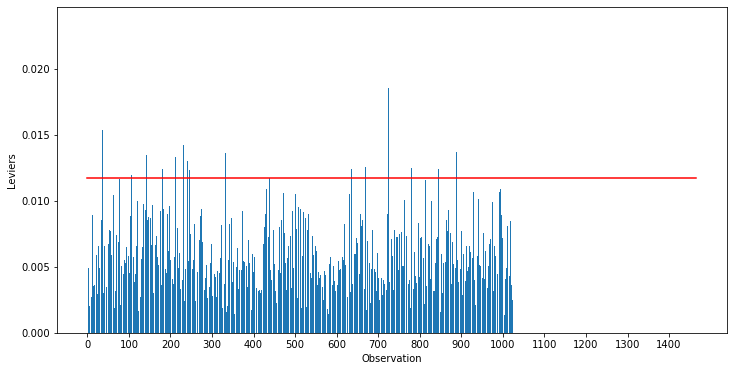

In [14]:
plt.figure(figsize=(12,6))
plt.bar(analyses['obs'], analyses['levier'])
plt.xticks(np.arange(0, 1465, step=100))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1465], [seuil_levier, seuil_levier], color='r')
plt.show()

##### <font color="black"> Analyse de la colinéarité </font>

In [15]:
variables = reg.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.015001614807184,
 1.1572661742237846,
 1.2511462550869474,
 1.3730447374716808,
 1.5877214940817959]

##### <font color="green"> Toutes les valeurs sont inférieures à 10, pas de problème de colinéarité  </font>

##### <font color="black"> Analyse de la normalité des résidus </font>

In [16]:
a,b = kstest(reg.resid, 'norm')
b

4.489398184348515e-34

<AxesSubplot:ylabel='Count'>

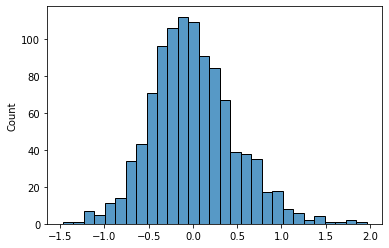

In [17]:
sns.histplot(x=reg.resid)

##### <font color="green"> L'hypothèse de normalité est remise en cause par le test de Kolmogorov
Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante (supérieure à 30) permettent de dire que les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes, même si le résidu n'est pas considéré comme étant gaussien. </font>

##### <font color="green"> On impute les valeurs manquantes à l'aide de notre regression  </font>

In [18]:
# Imputation des valeurs manquantes
df_na = billets[pd.isna(billets.margin_low)]
const = np.ones(len(df_na))
df_na.insert(loc=0, value=const, column="const")
x = df_na[["const","diagonal", "height_left", "height_right", "margin_up", "length"]]
y = reg.predict(x)
#billets.margin_low[pd.isna(billets.margin_low)]=y
billets.loc[pd.isna(billets.margin_low), "margin_low"]=y

<AxesSubplot:>

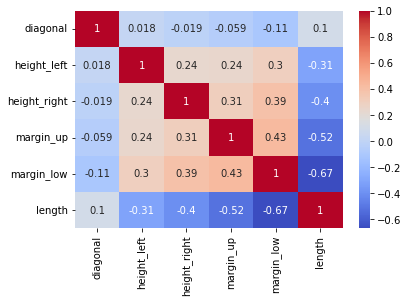

In [19]:
# Analyse des corrélations après imputation
billets_num = billets[["diagonal", "height_left", "height_right", "margin_up", "margin_low", "length"]]
tc=df_num.corr()
sns.heatmap(tc,annot=True,cmap="coolwarm")

##### <font color="green"> Les corrélations sont les mêmes avant et après imputation  </font>

# <font color="blue"> Régression logistique </font>

##### <font color="black"> On observe les tendances de chaque variable entre vrais et faux billets  </font>

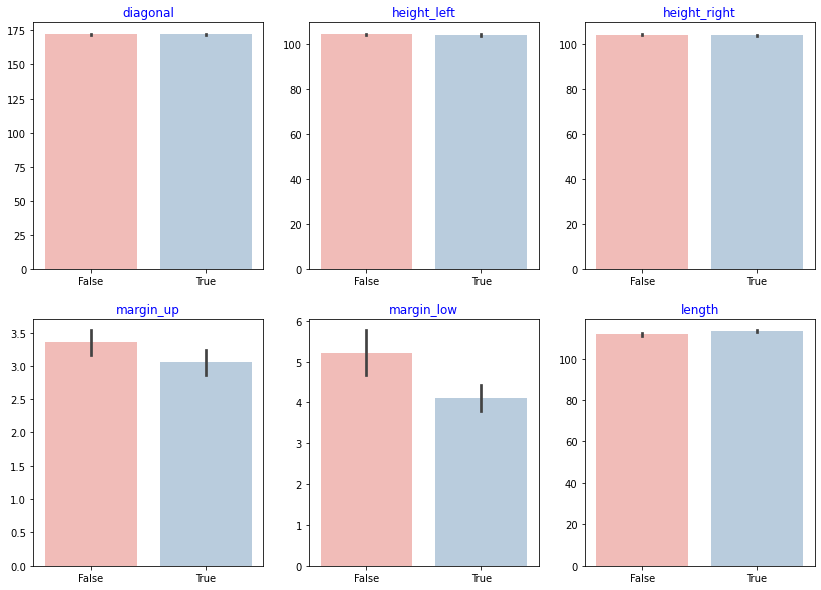

In [20]:
# Barplot
num_col = ["diagonal", "height_left", "height_right", "margin_up", "margin_low", "length"]
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14,10))
for col, i, j in zip(num_col, [0,0,0,1,1,1], [0,1,2,0,1,2]):
    g = sns.barplot(ax=ax[i,j], data=billets, y=col, x="is_genuine", estimator=np.mean, ci="sd", palette="Pastel1") 
    g.set(xlabel='', ylabel='')
    g.set_title(col, c="blue")

##### <font color="green"> Les vrais et faux billets semblent différer sur les variables margin_up et margin_low  </font>

##### <font color="black"> Mise en place de la régression logistique à l'aide de statmodels  </font>

In [21]:
x = df[["diagonal", "height_left", "height_right", "margin_up", "margin_low","length"]]
y = df[["is_genuine"]]
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=11)
xtrain1 = sm.add_constant(xtrain)
log_reg = sm.Logit(ytrain, xtrain1).fit() 

Optimization terminated successfully.
         Current function value: 0.020610
         Iterations 14


In [22]:
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             is_genuine   No. Observations:                 1024
Model:                          Logit   Df Residuals:                     1017
Method:                           MLE   Df Model:                            6
Date:                Wed, 17 Aug 2022   Pseudo R-squ.:                  0.9679
Time:                        13:51:19   Log-Likelihood:                -21.104
converged:                       True   LL-Null:                       -657.63
Covariance Type:            nonrobust   LLR p-value:                7.359e-272
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -74.0994    335.967     -0.221      0.825    -732.582     584.384
diagonal        -0.1196      1.455     -0.082      0.934      -2.972       2.733
height_left     -1.3246      1.656     -0.800      0.424      -4.570       1.920
height_right    -3.7466      1.562     -2.398      0.016      -6.809      -0.685
margin_up      -10.3612      2.890     -3.585      0.000     -16.026      -4.696
margin_low      -7.3473      1.637     -4.490      0.000     -10.555      -4.140
length           6.1216      1.178      5.196      0.000       3.812       8.431
================================================================================

Possibly complete quasi-separation: A fraction 0.62 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [23]:
xtest0 = sm.add_constant(xtest)
ypred = log_reg.predict(xtest0)
prediction = list(map(round, ypred))
accuracy_score(ytest, prediction)

0.9840546697038725

##### <font color="green"> On commence par enlever la variable la moins significative : diagonal </font>

In [24]:
xtrain2 = xtrain1.drop(columns="diagonal")
log_reg = sm.Logit(ytrain, xtrain2).fit() 
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.020613
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             is_genuine   No. Observations:                 1024
Model:                          Logit   Df Residuals:                     1018
Method:                           MLE   Df Model:                            5
Date:                Wed, 17 Aug 2022   Pseudo R-squ.:                  0.9679
Time:                        13:51:19   Log-Likelihood:                -21.108
converged:                       True   LL-Null:                       -657.63
Covariance Type:            nonrobust   LLR p-value:                4.400e-273
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -95.9404    206.004     -0.466      0.641    -499.701     307.820
height_left     -1.3022      1.634     -0.797      0.425      -4.504       1.900
height_right    -3.7465      1.568     -2.390      0.017      -6.819      -0.674
margin_up      -10.3308      2.860     -3.613      0.000     -15.936      -4.726
margin_low      -7.3118      1.571     -4.655      0.000     -10.391      -4.233
length           6.1098      1.166      5.240      0.000       3.825       8.395
================================================================================

Possibly complete quasi-separation: A fraction 0.61 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [25]:
xtest1 = xtest0.drop(columns=["diagonal"])
ypred = log_reg.predict(xtest1)
prediction = list(map(round, ypred))
accuracy_score(ytest, prediction)

0.9840546697038725

##### <font color="green"> La variable la moins significative est cette fois : height_left </font>

In [26]:
xtrain3 = xtrain2.drop(columns="height_left")
log_reg = sm.Logit(ytrain, xtrain3).fit() 
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.020926
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             is_genuine   No. Observations:                 1024
Model:                          Logit   Df Residuals:                     1019
Method:                           MLE   Df Model:                            4
Date:                Wed, 17 Aug 2022   Pseudo R-squ.:                  0.9674
Time:                        13:51:19   Log-Likelihood:                -21.428
converged:                       True   LL-Null:                       -657.63
Covariance Type:            nonrobust   LLR p-value:                3.189e-274
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -183.6474    179.134     -1.025      0.305    -534.744     167.449
height_right    -4.2984      1.522     -2.824      0.005      -7.282      -1.315
margin_up      -10.1849      2.825     -3.606      0.000     -15.721      -4.649
margin_low      -7.6050      1.565     -4.861      0.000     -10.672      -4.538
length           6.2026      1.173      5.288      0.000       3.904       8.502
================================================================================

Possibly complete quasi-separation: A fraction 0.62 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

##### <font color="green"> Cette fois toutes les variables sont significatives </font>

##### <font color="black"> On prédit les valeurs sur l'echantillon de test </font>

In [27]:
xtest2 = xtest1.drop(columns=["height_left"])
ypred = log_reg.predict(xtest2)
prediction = list(map(round, ypred))

In [28]:
precision = accuracy_score(ytest, prediction)
precision

0.9840546697038725

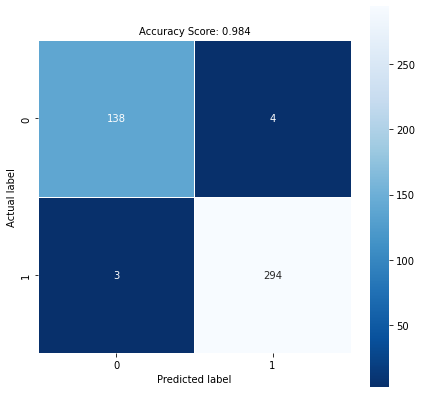

In [29]:
cm = confusion_matrix(ytest, prediction) 
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: '+ str(round(precision,3))
plt.title(all_sample_title, size = 10);

In [30]:
sensibilite = cm[1,1]/(cm[1,1]+cm[1,0])
specificite = cm[0,0]/(cm[0,0]+cm[0,1])
print("Précision du modèle : "+str(round(precision,2)*100)+"% ","Sensibilité du modèle : "+str(round(sensibilite,2)*100)+"% ","Spécificité du modèle : "+str(round(specificite,2)*100)+"%")

Précision du modèle : 98.0%  Sensibilité du modèle : 99.0%  Spécificité du modèle : 97.0%


##### <font color="green"> Conclusion : modèle très précis </font>

##### <font color="black"> Mise en place de la régression logistique à l'aide de scikit-learn  </font>

##### <font color="black"> Sans pénalisation  </font>

In [31]:
log_reg2 = LogisticRegression(penalty='none')
log_reg2 = log_reg2.fit(xtrain, ytrain.is_genuine)
log_reg2.score(xtest, ytest)

0.9840546697038725

##### <font color="black"> Avec pénalisation de type L2  </font>

In [32]:
log_reg3 = LogisticRegression(penalty='l2')
log_reg3 = log_reg3.fit(xtrain, ytrain.is_genuine)
log_reg3.score(xtest, ytest)

0.9863325740318907

##### <font color="black"> Avec pénalisation de type L1  </font>

In [33]:
log_reg4 = LogisticRegression(penalty='l1', solver='liblinear')
log_reg4 = log_reg4.fit(xtrain, ytrain.is_genuine)
log_reg4.score(xtest, ytest)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.9817767653758542

##### <font color="black"> Avec méthode de cross-validation  </font>

In [34]:
parameters = {'C':[.01, .1, 1, 10]}
logit = GridSearchCV(LogisticRegression(penalty="l2", solver="lbfgs"),
parameters,cv=5)
logitOpt=logit.fit(xtrain, ytrain.is_genuine)

log_reg5 = LogisticRegression(penalty='l2', C=logitOpt.best_params_["C"])
log_reg5 = log_reg5.fit(xtrain, ytrain.is_genuine)
log_reg5.score(xtest, ytest)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

0.9863325740318907

##### <font color="green"> La régression est plus précise avec pénalisation du modèle de type L2 </font>

In [35]:
precision = log_reg3.score(xtest, ytest)
prediction = log_reg3.predict(xtest)
cm = confusion_matrix(ytest, prediction) 

Text(0.5, 1.0, 'Accuracy Score: 0.986')

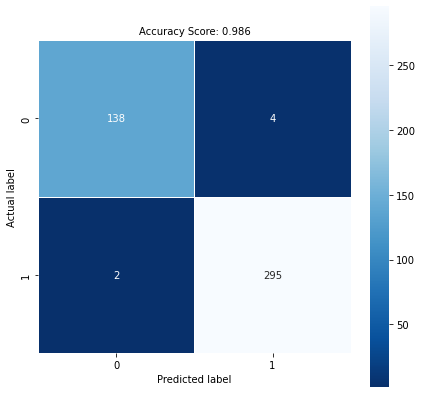

In [36]:
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: '+ str(round(precision,3))
plt.title(all_sample_title, size = 10)

In [37]:
sensibilite = cm[1,1]/(cm[1,1]+cm[1,0])
specificite = cm[0,0]/(cm[0,0]+cm[0,1])
print("Précision du modèle : "+str(round(precision,3)*100)+"%""Sensibilité du modèle : "+str(round(sensibilite,3)*100)+"%","Spécificité du modèle : "+str(round(specificite,3)*100)+"%")

Précision du modèle : 98.6%Sensibilité du modèle : 99.3% Spécificité du modèle : 97.2%


##### <font color="green"> Conclusion : on retient le modele de sickit learn avec pénalisation de type L2 </font>

##### <font color="black"> On va maintenant regarder en détail les erreurs </font>

In [38]:
df_verif = xtest.merge(ytest,left_index=True, right_index=True)
df_verif.insert(loc=7, column="predict", value=prediction)

In [39]:
def classification(tab):
    if tab.is_genuine == True and tab.predict == True:
        return "VP"
    elif tab.is_genuine == False and tab.predict == False:
        return "VN"
    elif tab.is_genuine == True and tab.predict == False:
        return "FN"
    elif tab.is_genuine == False and tab.predict == True:
        return "FP"

classement = df_verif.apply(classification, axis=1)
df_verif.insert(loc=8, column="classement", value=classement)

In [40]:
piv = df_verif.pivot_table(index="classement", values=["diagonal", "height_left", "height_right", "margin_up", "margin_low", "length"], aggfunc=np.mean)
piv

,diagonal,height_left,height_right,length,margin_low,margin_up
classement,,,,,,
FN,172.060000,104.390000,104.140000,112.600000,4.650000,3.115000
FP,172.067500,104.017500,103.967500,112.740000,4.172500,3.302500
VN,171.871522,104.177464,104.159275,111.591232,5.261232,3.358116
VP,171.976441,103.937966,103.835593,113.195153,4.120305,3.057966


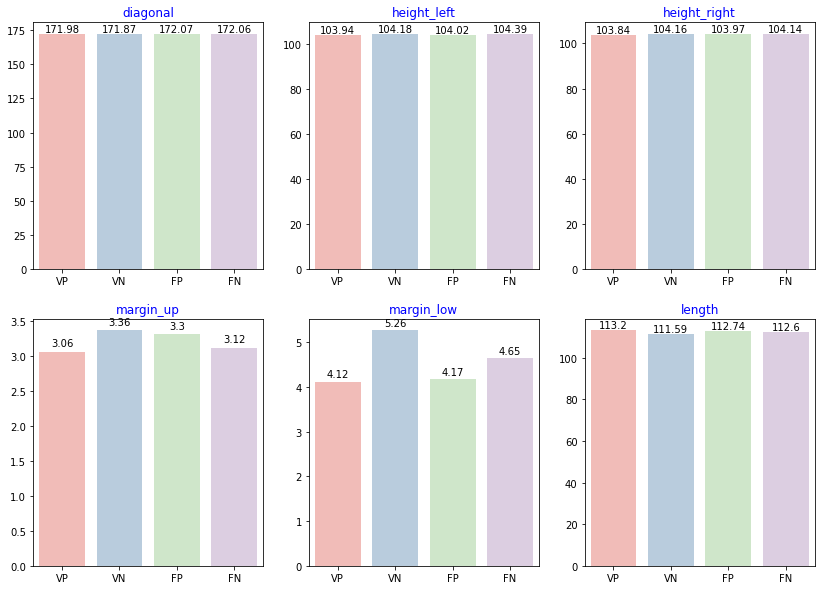

In [41]:
# Barplot
num_col = ["diagonal", "height_left", "height_right", "margin_up", "margin_low", "length"]
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14,10))
for col, i, j in zip(num_col, [0,0,0,1,1,1], [0,1,2,0,1,2]):
    g = sns.barplot(ax=ax[i,j], data=df_verif, y=col, x=classement,ci=None, estimator=np.mean, palette="Pastel1") 
    g.set(xlabel='', ylabel='')
    g.set_title(col, c="blue")
    
    labels = [round(piv[col].loc["VP"],2), round(piv[col].loc["VN"],2), round(piv[col].loc["FP"],2), round(piv[col].loc["FN"],2)]
    rects = g.patches
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        g.text(
            rect.get_x() + rect.get_width() / 2, height + 0.05, label, ha="center", va="bottom"
        )

# <font color="blue"> K-Means </font>

In [42]:
# Centrage et réduction des variables
std_scale = preprocessing.StandardScaler().fit(xtrain)
xtrain_scaled = std_scale.transform(xtrain)
std_scale = preprocessing.StandardScaler().fit(xtest)
xtest_scaled = std_scale.transform(xtest)

# Mise en place du KMEANS
km = KMeans(n_clusters= 2)
km.fit(xtrain_scaled)
clusters_kmeans = km.labels_
centroids_after_kmeans = km.cluster_centers_

Text(0.5, 1.0, 'The Elbow Method using Inertia')

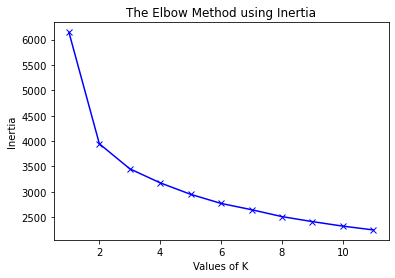

In [43]:
# Diagramme d'inertie
inertias = [] 
mapping = {} 
K = range(1,12) 
  
for k in K: 
    kmeanModel = KMeans(n_clusters=k).fit(xtrain_scaled)   
    kmeanModel.fit(xtrain_scaled) 
    
    inertias.append(kmeanModel.inertia_) 
  
    mapping[k] = kmeanModel.inertia_ 
    
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 

In [44]:
# Prédictions
prediction = km.predict(xtest_scaled)
prediction_inv = []
for elt in prediction :
    if elt ==1 :
        pred = 0
    else :
        pred = 1
    prediction_inv.append(pred)
prediction_inv = np.array(prediction_inv)
precision1 = accuracy_score(ytest, prediction_inv)
precision2 = accuracy_score(ytest, prediction)
if precision1 > precision2 :
    precision = precision1
    prediction = prediction_inv
else :
    precision = precision2  

precision

0.9749430523917996

Text(0.5, 1.0, 'Accuracy Score: 0.975')

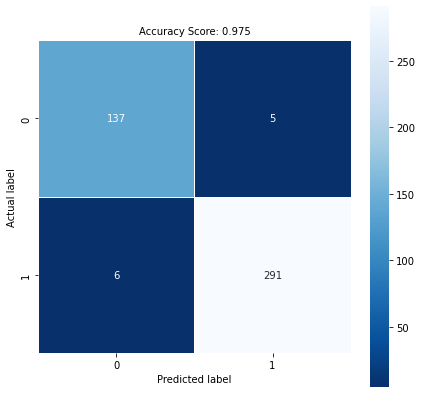

In [45]:
cm = confusion_matrix(ytest, prediction) 
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: '+ str(round(precision,3))
plt.title(all_sample_title, size = 10)

##### <font color="green"> Conclusion : KMeans est légèrement moins précis que la régression logistique </font>

# <font color="blue"> SGD </font>

In [46]:
# Mise en place du SGD
sgd = SGDClassifier(loss="log",penalty="none",learning_rate="constant",eta0=0.1,max_iter=100,tol=None)

In [47]:
# Application du SGD à nos données
sgd.fit(xtrain, ytrain.is_genuine)

SGDClassifier(eta0=0.1, learning_rate='constant', loss='log', max_iter=100,
              penalty='none', tol=None)

In [48]:
# Nombre d'itérations réalisées
sgd.n_iter_

100

In [49]:
# Prédictions des données de test
prediction = sgd.predict(xtest)

In [50]:
# Précision du modèle
precision = accuracy_score(ytest, prediction)
precision

0.9840546697038725

In [51]:
# Matrice de confusion
cm = confusion_matrix(ytest, prediction) 

Text(0.5, 1.0, 'Accuracy Score: 0.984')

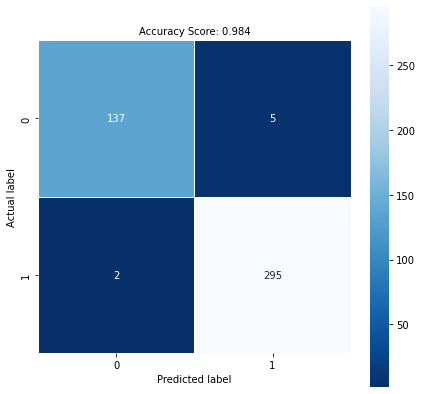

In [52]:
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: '+ str(round(precision,3))
plt.title(all_sample_title, size = 10)

# <font color="black"> Test sur autres données </font>

## Format "billets"

In [53]:
data = pd.read_csv("Data/billets.csv", sep=";")
data = data.dropna()
data.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [54]:
def model_pred(data, reg=log_reg3): # log_reg3 = regression logistique avec penalisation L2
    x = data[["diagonal", "height_left", "height_right", "margin_up", "margin_low","length"]]
    y = data[["is_genuine"]]
    precision = reg.score(x, y)
    prediction = reg.predict(x)
    cm = confusion_matrix(y, prediction) 
    plt.figure(figsize=(7,7))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: '+ str(round(precision,3))
    plt.title(all_sample_title, size = 10)
    return precision
    

0.9904306220095693

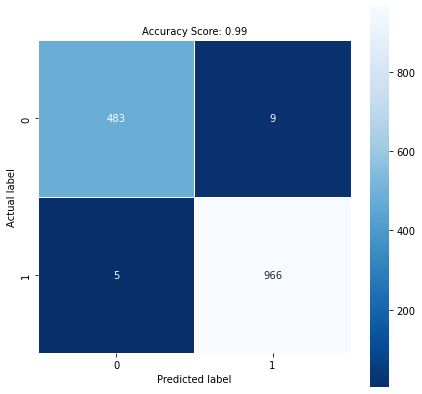

In [55]:
model_pred(data)

## Format "billets_production" (soutenance)

In [59]:
data = pd.read_csv("Data/billets_test_ML_P10.csv", sep=",")
data.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5


In [60]:
def model_pred2(data, reg=log_reg3): # log_reg3 = regression logistique avec penalisation L2
    x = data[["diagonal", "height_left", "height_right", "margin_up", "margin_low","length"]]
    prediction = reg.predict(x)
    data.insert(loc=7, column="prediction", value=prediction)
    return data
   

In [61]:
model_pred2(data)

,diagonal,height_left,height_right,margin_low,margin_up,length,id,prediction
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1,True
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2,False
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3,True
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4,False
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5,False
